In [1]:
import sys, os

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/sines_2/orig_0_1_2_cnmp/1717369655/'

data_path = root_path + test_path + 'y.pt'

Y = torch.load(data_path, map_location='cpu').to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])
print(f'x: {x.shape}, Y: {Y.shape}')

num_modes = 2
num_indiv = Y.shape[0]//num_modes
t_steps = Y.shape[1]

Y_means = np.zeros((num_modes,Y.shape[1]))
for i in range(num_modes):
    inds = np.arange(num_indiv)*num_modes+i
    Y_means[i] = np.mean(Y[inds], axis=0)

x: (200,), Y: (128, 200)


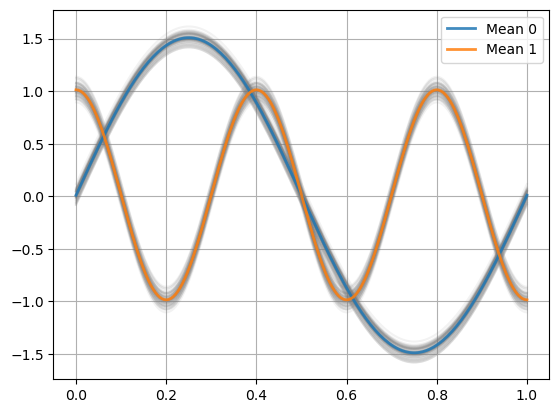

In [3]:
# plot Y and Y_means
plt.plot(x, Y.T, color='gray', alpha=0.1)
for i, traj in enumerate(Y_means):
    plt.plot(x, traj, label=f'Mean {i}', alpha=0.85, linewidth=2)
plt.legend()
plt.grid()
plt.show()

In [4]:
def find_closest_traj_ind(traj):
    # find the closest trajectory in the dataset
    min_dist = np.inf
    min_ind = -1
    for i, y in enumerate(Y):
        dist = compute_rmse(y, traj)  # euclidean distance between two trajectories
        if dist < min_dist:
            min_dist = dist
            min_ind = i
    return min_ind


def compute_rmse(traj0, traj1, cut=0):
    # RMSE between two trajs
    t0 = traj0.reshape(t_steps, -1)
    t1 = traj1.reshape(t_steps, -1)
    assert t0.shape == t1.shape, f"Trajectories should have the same shape, but got {t0.shape} and {t1.shape}"
    if cut != 0:
        return np.sqrt(np.mean((t0[:-cut] - t1[:-cut]) ** 2))
    return np.sqrt(np.mean((t0 - t1) ** 2))


def compute_mae(traj0, traj1, cut=0):
    # MAE between two trajs
    t0 = traj0.reshape(t_steps, -1)
    t1 = traj1.reshape(t_steps, -1)
    assert t0.shape == t1.shape, f"Trajectories should have the same shape, but got {t0.shape} and {t1.shape}"
    if cut != 0:
        return np.mean(np.abs(t0[:-cut] - t1[:-cut]))
    return np.mean(np.abs(t0 - t1))


def compute_max_error(traj0, traj1, cut=0):
    # maximum error between two trajs
    t0 = traj0.reshape(t_steps, -1)
    t1 = traj1.reshape(t_steps, -1)
    assert t0.shape == t1.shape, f"Trajectories should have the same shape, but got {t0.shape} and {t1.shape}"
    if cut != 0:
        return np.max(np.abs(t0[:-cut] - t1[:-cut]))
    return np.max(np.abs(t0 - t1))

In [5]:
model_folder = 'saved_models/'
models_path = f'{root_path}{test_path}{model_folder}'

m_path, m0_path, m1_path, m2_path, m3_path = f'{models_path}org.pt', f'{models_path}abl0.pt', f'{models_path}abl1.pt', f'{models_path}abl2.pt', f'{models_path}cnmp.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 6, 6
t_steps = Y.shape[1]
device = 'cpu'

cnmp = CNMP(dx, dy, n_max, m_max, [158,158], decoder_hidden_dims=[158,158], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep0 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep1 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)
cnep2 = CNEP(dx, dy, n_max, m_max, [128,128], num_decoders=2, decoder_hidden_dims=[128, 128], batch_size=batch_size, scale_coefs=True, device=device)

cnep.load_state_dict(torch.load(m_path, map_location='cpu'))
cnep0.load_state_dict(torch.load(m0_path, map_location='cpu'))
cnep1.load_state_dict(torch.load(m1_path, map_location='cpu'))
cnep2.load_state_dict(torch.load(m2_path, map_location='cpu'))
cnmp.load_state_dict(torch.load(m3_path, map_location='cpu'))


# data for testing cnxp
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

val_obs_mask[0, :2] = True

val_tar_x[0] = torch.linspace(0, 1, t_steps).unsqueeze(1)
val_obs[0, :2, :dx] = torch.tensor([0, 1]).unsqueeze(1)

In [6]:
# n_components = 20  # Number of GMM components
# gmr_model = GMM(n_components=n_components, random_state=1234)
# gmr_model = gmr_model.from_samples(Y)

# ind = 0
# val = 0.5
# gmr_model_ = gmr_model.condition([ind], [val])
# trajectory_g = gmr_model_.sample(1)
# trajectory_g = np.insert(trajectory_g, ind, val)

# val_obs_mask[0, 0] = True
# val_obs[0, :1, :dx] = torch.tensor([0]).unsqueeze(1)
# val_obs[0, :1, dx:] = torch.tensor([val]).unsqueeze(1)
# with torch.no_grad():
#     trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
#     pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
#     dec_id = torch.argmax(gate.squeeze(1), dim=-1)
#     trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]


# plt.plot(x, Y.T, color='gray', alpha=0.1)
# plt.plot(x, trajectory_g, label='GMM', alpha=0.85, linewidth=2)
# plt.plot(x, trajectory_cnmp[0,:,0], label='CNMP', alpha=0.85, linewidth=2)
# plt.plot(x, trajectory_cnep[0,:,0], label='CNEP', alpha=0.85, linewidth=2)
# plt.scatter(x[ind], Y[0, ind], marker='*', c='green', s=80, label='')
# plt.legend()
# plt.grid()
# plt.show()

In [7]:
from tqdm import tqdm

num_demos = Y.shape[0]
num_tests = 30

# y0 = np.mean(Y[:, 0])
# y1_min, y1_max = np.min(Y[:, -1]), np.max(Y[:, -1])

y0_min, y0_max = np.min(Y[:, 0]), np.max(Y[:, 0])
y1s = Y_means[:, -1]

y0s = np.linspace(y0_min, y0_max, num_tests)

num_models = 10
# 0: DMP, 1: ProMP, 2: GMR, 3: CNMP, 4: StableMP, 5:CNEP, 6: CNEP-MoE, 7: CNEP-A0, 8: CNEP-A1, 9: CNEP-A2

rmse_errors = np.zeros((num_tests*num_modes, num_models))  # num_models models
mae_errors = np.zeros((num_tests*num_modes, num_models))
max_errors = np.zeros((num_tests*num_modes, num_models))

smp_trajs = np.load('bimodal_smp.npy')

for i1 in range(num_modes):
    for i0 in tqdm(range(num_tests)):
        d = DMP(n_dims=1, n_weights_per_dim=20, dt=(1/199))

        for traj in Y:
            d.imitate(x, traj.reshape(-1,1))

        p = ProMP(n_dims=1, n_weights_per_dim=20)
        p.imitate(np.tile(x, (num_demos, 1)), Y)

        input_data = x.reshape(-1, 1)  # Phase variable as a column vector

        priors = 20  # Number of GMM components
        gmr_model = GMM(n_components=priors, random_state=1234)
        gmr_model.from_samples(Y)

        y0 = y0s[i0]
        y1 = y1s[i1]

        # DMP
        d.configure(start_y=[y0], goal_y=[y1])
        t, trajectory = d.open_loop()

        # ProMP
        p = p.condition_position(y0, t=0).condition_position(y1, t=1)
        trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

        # GMR
        gmr_model_ = gmr_model.condition([0, -1], [y0, y1])
        trajectory_g = gmr_model_.sample(1)
        trajectory_g = np.insert(trajectory_g, 0, y0)
        trajectory_g = np.append(trajectory_g, y1)

        # CNMP and CNEP
        val_obs[0, :2, dx:] = torch.tensor([y0, y1]).unsqueeze(1)

        with torch.no_grad():
            trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
            pred_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
            dec_id = torch.argmax(gate.squeeze(1), dim=-1)
            trajectory_cnep = pred_cnep[dec_id, 0, :, :dy]

            confs = gate.view(2, 1, 1, 1)
            preds = pred_cnep[:, :, :, :dy]

            weighted_preds = preds * confs  # Element-wise multiplication, shape (num_gates, 1, 200, 1)
            trajectory_cnep_moe = weighted_preds.sum(dim=0, keepdim=True)  # Sum along the first dimension, shape (1, 1, 200, 1)

            pred_cnep0, gate0 = cnep0.val(val_obs, val_tar_x, val_obs_mask)
            dec_id0 = torch.argmax(gate0.squeeze(1), dim=-1)
            trajectory_cnep0 = pred_cnep0[dec_id0, 0, :, :dy]

            pred_cnep1, gate1 = cnep1.val(val_obs, val_tar_x, val_obs_mask)
            dec_id1 = torch.argmax(gate1.squeeze(1), dim=-1)
            trajectory_cnep1 = pred_cnep1[dec_id1, 0, :, :dy]

            pred_cnep2, gate2 = cnep2.val(val_obs, val_tar_x, val_obs_mask)
            dec_id2 = torch.argmax(gate2.squeeze(1), dim=-1)
            trajectory_cnep2 = pred_cnep2[dec_id2, 0, :, :dy]


        for j in range(num_models):
            if j == 0:
                traj = trajectory
            elif j == 1:
                traj = trajectory_p.squeeze(0)
            elif j == 2:
                traj = trajectory_g
            elif j == 3:
                traj = trajectory_cnmp.squeeze(0).squeeze(-1).numpy()
            elif j == 4:  # offline test
                traj = smp_trajs[i1*num_tests+i0]
            elif j == 5:
                traj = trajectory_cnep.squeeze(0).squeeze(-1).numpy()
            elif j == 6:
                traj = trajectory_cnep_moe.squeeze(0).squeeze(0).squeeze(-1).numpy()
            elif j == 7:
                traj = trajectory_cnep0.squeeze(0).squeeze(-1).numpy()
            elif j == 8:
                traj = trajectory_cnep1.squeeze(0).squeeze(-1).numpy()
            elif j == 9:
                traj = trajectory_cnep2.squeeze(0).squeeze(-1).numpy()

            closest_traj_ind = find_closest_traj_ind(traj)

            cut = 0
            if j == 4:
                cut = 3

            rmse_errors[i1*num_tests+i0, j] = compute_rmse(traj, Y[closest_traj_ind], cut)
            mae_errors[i1*num_tests+i0, j] = compute_mae(traj, Y[closest_traj_ind], cut)
            max_errors[i1*num_tests+i0, j] = compute_max_error(traj, Y[closest_traj_ind], cut)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [09:37<00:00, 19.24s/it]


In [8]:
# print mean errors and standard deviations
print('RMSE')
print(np.mean(rmse_errors, axis=0))
print(np.std(rmse_errors, axis=0))
print('MAE')
print(np.mean(mae_errors, axis=0))
print(np.std(mae_errors, axis=0))
print('Max error')
print(np.mean(max_errors, axis=0))
print(np.std(max_errors, axis=0))

RMSE
[0.45994745 0.37790549 0.61529102 0.49892191 0.22335182 0.09152463
 0.24192438 0.46973568 0.21758042 0.57535946]
[0.30973827 0.25921632 0.2296266  0.10663707 0.18163438 0.05842266
 0.2083631  0.38913402 0.19350604 0.14356535]
MAE
[0.41885392 0.30924941 0.55321216 0.42820035 0.17753615 0.07164399
 0.18647417 0.36446672 0.20939257 0.4706352 ]
[0.3098692  0.21588102 0.20646245 0.09223928 0.1783344  0.04804612
 0.16198002 0.29475716 0.19503881 0.14360913]
Max error
[0.70992517 0.77463685 0.8810348  0.81205867 0.41829678 0.2997889
 0.56669894 1.32164664 0.29085433 1.28572656]
[0.34368439 0.54269596 0.32883083 0.15720912 0.32783742 0.11184661
 0.31528565 1.29614173 0.22378112 0.2556726 ]


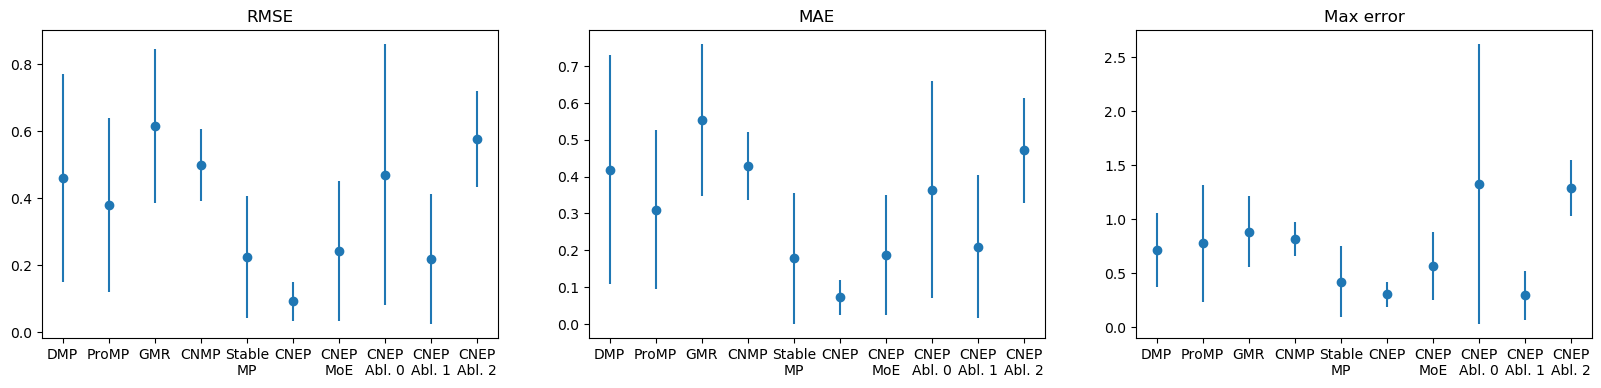

In [9]:
# plot mean errors and standard deviations 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
ax[0].set_title('RMSE')
ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
ax[1].set_title('MAE')
ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
ax[2].set_title('Max error')
plt.show()
# plt.savefig('table2_0.png')

# fig, ax = plt.subplots(1, 3, figsize=(20, 4))
# # x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP', 'CNEP\nMoE', 'CNEP\nAbl. 0', 'CNEP\nAbl. 1', 'CNEP\nAbl. 2']
# x_labels = ['DMP', 'ProMP', 'GMR', 'CNMP', 'Stable\nMP', 'CNEP']
# ax[0].errorbar(x_labels, np.mean(rmse_errors, axis=0), np.std(rmse_errors, axis=0), fmt='o')
# ax[0].set_title('RMSE')
# ax[1].errorbar(x_labels, np.mean(mae_errors, axis=0), np.std(mae_errors, axis=0), fmt='o')
# ax[1].set_title('MAE')
# ax[2].errorbar(x_labels, np.mean(max_errors, axis=0), np.std(max_errors, axis=0), fmt='o')
# ax[2].set_title('Max error')
# plt.show()

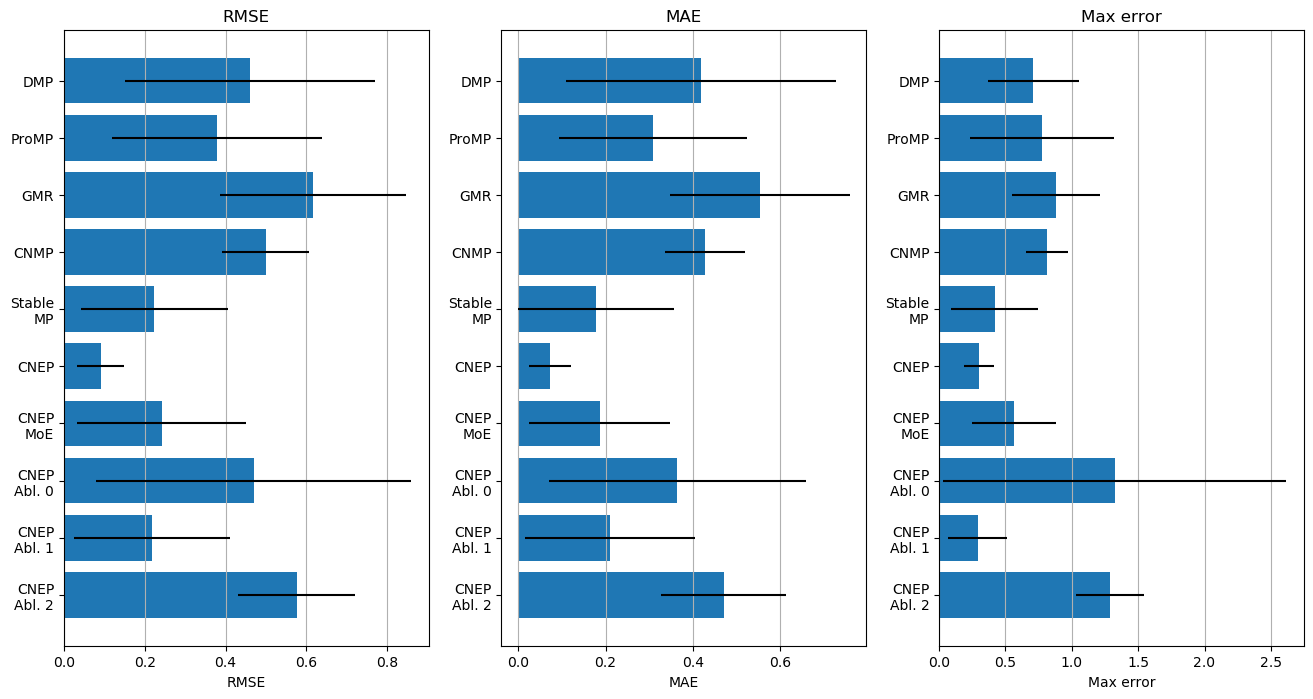

In [10]:
# plot mean errors and standard deviations as horizontal bars
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
y_pos = np.arange(len(x_labels))
ax[0].barh(y_pos, np.mean(rmse_errors, axis=0), xerr=np.std(rmse_errors, axis=0), align='center')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(x_labels)
ax[0].invert_yaxis()
ax[0].set_xlabel('RMSE')
ax[0].set_title('RMSE')
ax[1].barh(y_pos, np.mean(mae_errors, axis=0), xerr=np.std(mae_errors, axis=0), align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(x_labels)
ax[1].invert_yaxis()
ax[1].set_xlabel('MAE')
ax[1].set_title('MAE')
ax[2].barh(y_pos, np.mean(max_errors, axis=0), xerr=np.std(max_errors, axis=0), align='center')
ax[2].set_yticks(y_pos)
ax[2].set_yticklabels(x_labels)
ax[2].invert_yaxis()
ax[2].set_xlabel('Max error')
ax[2].set_title('Max error')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
ax[2].grid(axis='x')
plt.show()
# plt.savefig('table2_1.png')